# Baseline学习笔记

由于本人基础不足，本次任务计划将BaseLine跑通，并尽量理解BaseLine代码。代码在DSW上运行， 由于DSW内存有限，删除部分图片，只保留300张。但是在DSW上跑模型训练时，总是报Server disconnect错误。不知原因， 等下次我将代码放在Colab上运行。下面只是将BaseLine代码复制过来，并且对部分代码进行注释。

## 代码分析

In [13]:
#!pip install opencv-python --user
#!pip install --upgrade pip
#!pip install tqdm --user
#!pip install albumentations --user
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import cv2, gc
from tqdm import tqdm_notebook
#from tqdm_notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#from tqdm.notebook import tqdm

import albumentations as A

#import rasterio
#from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


rle_encode函数将图片转换为rle格式，rle_decode将rle格式的数据解码成图片。
RLE压缩算法（下简称RLE算法）的基本思路是把数据按照线性序列分成两种情况：一种是连续的重复数据块，另一种是连续的不重复数据块。  
RLE算法的原理就是用一个表示块数的属性加上一个数据块代表原来连续的若干块数据，从而达到节省存储空间的目的。一般RLE算法都选择数据块的长度为 1 字节，表示块数的诚性也用1字节表示，对于颜色数小于 256 色的图像文件或文本文件，块长度选择 1 字节是比较合适的。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [ ]:
EPOCHES = 20
BATCH_SIZE = 32
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


定义数据集，TianChiDataset是自定义数据集，用于数据预处理。 
as_tensor，将图像resize到256 x 256，使用均值、方差标准化等预处理方式。  
这里最主要是__getitem__函数， 在获取数据时，通过Cv2.imread函数读取加载的数据字典中的图片路径，如果是训练模式，则获取数据字典中对应的Mask的rle字符串，并解码成mask图片。augments['mask'][None]中的[None]将（256，256）的mask形状转为（1，256，256），起到升维作用。

In [ ]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [ ]:
train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: 'train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

In [ ]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

打印第一幅图和MASK图，进行对比。可以看出，有建筑物的区域都在MASK图上被标出

In [ ]:
image, mask = dataset[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

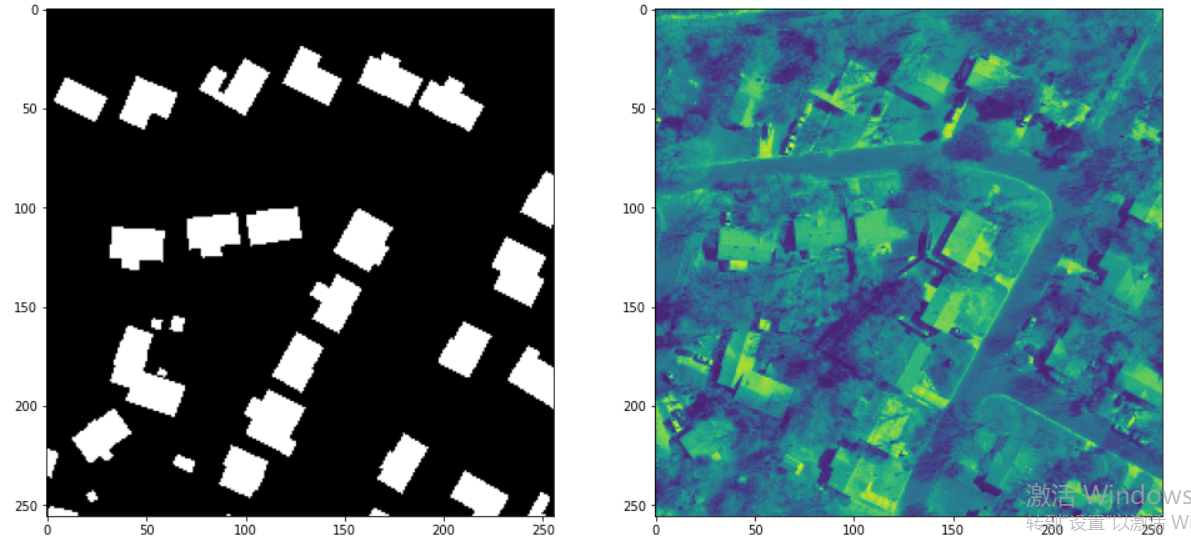

分割训练集和验证集：  
每7条数据中取一条数据放入验证集，6条放入训练集。  
Pytorch的DataLoader便于加载和迭代处理数据,batch_size指每批加载数目。

In [ ]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 7 == 0:
        valid_idx.append(i)
#     else:
    elif i % 7 == 1:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
get_model函数原来使用fcn_resnet50，代码实际运行出错（估计torchvision版本问题），改成fcn_resnet101运行成功。  
该函数创建一个fcn_resnet101模型进行图像语义分割。图像语义分割的输出需要是个分割图，且不论尺寸大小，但是至少是二维的。所以，我们需要丢弃全连接层，换上全卷积层，而这就是全卷积网络了。  
具体定义请参看论文：Fully Convolutional Networks for Semantic Segmentation

In [ ]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet101(True)
    
#     pth = torch.load("../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [ ]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

In [ ]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 5
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')

In [ ]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("./model_best.pth"))
model.eval()

In [ ]:
FCN(
,  (backbone): IntermediateLayerGetter(
,    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
,    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,    (relu): ReLU(inplace=True)
,    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
,    (layer1): Sequential(
,      (0): Bottleneck(
,        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,        (downsample): Sequential(
,          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        )
,      )
,      (1): Bottleneck(
,        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (2): Bottleneck(
,        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,    )
,    (layer2): Sequential(
,      (0): Bottleneck(
,        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,        (downsample): Sequential(
,          (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
,          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        )
,      )
,      (1): Bottleneck(
,        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (2): Bottleneck(
,        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (3): Bottleneck(
,        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,    )
,    (layer3): Sequential(
,      (0): Bottleneck(
,        (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,        (downsample): Sequential(
,          (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,          (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        )
,      )
,      (1): Bottleneck(
,        (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (2): Bottleneck(
,        (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (3): Bottleneck(
,        (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (4): Bottleneck(
,        (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (5): Bottleneck(
,        (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,    )
,    (layer4): Sequential(
,      (0): Bottleneck(
,        (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
,        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,        (downsample): Sequential(
,          (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
,          (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        )
,      )
,      (1): Bottleneck(
,        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
,        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,      (2): Bottleneck(
,        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), bias=False)
,        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
,        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,        (relu): ReLU(inplace=True)
,      )
,    )
,  )
,  (classifier): FCNHead(
,    (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,    (2): ReLU()
,    (3): Dropout(p=0.1, inplace=False)
,    (4): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
,  )
,  (aux_classifier): FCNHead(
,    (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
,    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
,    (2): ReLU()
,    (3): Dropout(p=0.1, inplace=False)
,    (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
,  )
,)


In [ ]:
test_mask = pd.read_csv('数据集/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '数据集/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [ ]:
subm = pd.DataFrame(subm)
subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('数据集/test_a/' + subm[0].iloc[0]));
